<a href="https://colab.research.google.com/github/mohsensafa/TensorFlow/blob/master/Multi_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPool2D, Activation, Flatten, Dropout, Dense, Input, InputLayer, Lambda
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import pickle
import cv2
import os
from google.colab import drive
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
import datetime

drive.mount('/gdrive')
%load_ext tensorboard.notebook

In [0]:
dataset = '/gdrive/My Drive/dataset_cars'

pic_path = []
data = []
labels = []
category = []
color = []

for root, dir, file in os.walk(dataset):
  for name in file:
    pic_path.append(os.path.join(root, name))

random.shuffle(pic_path)
    
for imagePath in pic_path:
  image = cv2.imread(imagePath)
  image = cv2.resize(image, (96, 96))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  data.append(image)
  (col , cat) = imagePath.split(os.path.sep)[-2].split('_')
  category.append(cat)
  color.append(col)

#scale the data to the range [0, 1]
data = np.array(data, dtype='float') / 255.0
category = np.array(category)
color = np.array(color)
print(f'Number of images: {len(pic_path)}')

Number of images: 448


In [0]:
labeledCat = LabelBinarizer()
labeledColor = LabelBinarizer()
labeled_cat = labeledCat.fit_transform(category)
labeled_col = labeledColor.fit_transform(color)

#in case of having only 2 classes:
from tensorflow.keras.utils import to_categorical
categorical_labels = to_categorical(labeled_cat)

#in case of 2 class, change "labeled_cat" or "labeled_col" with categorical_labels
(trainX, testX, traincatY, testcatY, traincolY, testcolY) = train_test_split(data, categorical_labels, labeled_col, test_size=0.2)

num_colors = len(labeledColor.classes_)
num_cats = len(labeledCat.classes_)
inputs = Input(shape=(96,96,3))

In [0]:
print(categorical_labels)

In [0]:
def category_model(inputs):
  #model = Sequential()
  
  #model.add(InputLayer(input_tensor=inputs))
  #model.add(InputLayer(input_shape=(96,96,3)))
  model=Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)
  model=Conv2D(32, (3, 3), padding='same')(model)
  model=Activation('relu')(model)
  model=BatchNormalization()(model)
  model=MaxPool2D(pool_size=(2, 2))(model)
  model=Dropout(0.3)(model)

  model=Conv2D(64, (3, 3), padding='same')(model)
  model=Activation('relu')(model)
  model=BatchNormalization()(model)
  model=Conv2D(64, (3, 3), padding='same')(model)
  model=Activation('relu')(model)
  model=BatchNormalization()(model)
  #model=MaxPooling2D(pool_size=(2, 2)))
  model=Dropout(0.3)(model)

  model=Conv2D(128, (3, 3), padding='same')(model)
  model=Activation('relu')(model)
  model=BatchNormalization()(model)
  model=Conv2D(128, (3, 3), padding='same')(model)
  model=Activation('relu')(model)
  model=BatchNormalization()(model)
  model=MaxPool2D(pool_size=(2, 2))(model)
  model=Dropout(0.3)(model)

  model=Flatten()(model)
  model=Dense(1024)(model)
  model=Activation('relu')(model)
  model=BatchNormalization()(model)
  model=Dropout(0.5)(model)

  model=Dense(num_cats)(model)
  model=Activation('softmax', name='category_output')(model)
  
  return model

In [0]:
def color_model(inputs):
  #model = Sequential()
  
  #model.add(InputLayer(input_tensor=inputs))
  #model.add(InputLayer(input_shape=(96,96,3)))
  model=Conv2D(16, (3, 3), padding='same')(inputs)
  model=Activation('relu')(model)
  model=BatchNormalization()(model)
  model=MaxPool2D(pool_size=(3, 3))(model)
  model=Dropout(0.15)(model)

  model=Conv2D(32, (3, 3), padding='same')(model)
  model=Activation('relu')(model)
  model=BatchNormalization()(model)
  model=MaxPool2D(pool_size=(2, 2))(model)
  model=Dropout(0.15)(model)

  model=Conv2D(32, (3, 3), padding='same')(model)
  model=Activation('relu')(model)
  model=BatchNormalization()(model)
  model=MaxPool2D(pool_size=(2, 2))(model)
  model=Dropout(0.15)(model)
  
  model=Flatten()(model)
  model=Dense(128)(model)
  model=Activation('relu')(model)
  model=BatchNormalization()(model)
  model=Dropout(0.5)(model)
  model=Dense(num_colors)(model)
  model=Activation('softmax', name='color_output')(model)
  
  return model

In [0]:
!rm -rf /content/logs/

In [0]:
inputs = Input(shape=(96,96,3))

cat_model=category_model(inputs)
col_model=color_model(inputs)

In [0]:
epoch = 50
init_learning = 1e-3

losses = {'category_output': 'categorical_crossentropy', 'color_output': 'categorical_crossentropy'}
lossWeights = {'category_output': 1.0, 'color_output': 1.0}
model = Model(inputs=inputs, outputs=[cat_model,col_model])
opt = Adam(lr=init_learning, decay=init_learning / epoch)

model.compile(optimizer=opt, loss=losses, loss_weights=lossWeights, metrics=['accuracy'])
log_dir='/content/logs/' + datetime.datetime.now().strftime('%m-%d--%H:%M')

In [0]:
model.fit(trainX,{'category_output': traincatY, 'color_output': traincolY}, validation_data=(testX, {'category_output': testcatY, 'color_output': testcolY}),
          epochs=epoch, callbacks=[TensorBoard(log_dir), ModelCheckpoint(filepath='/content/logs/weights.{epoch:02d}-{val_loss:.2f}.h5')])

Train on 358 samples, validate on 90 samples
Epoch 1/50
358/358 [==============================] - 7s 19ms/sample - loss: 0.0675 - category_output_loss: 0.0229 - color_output_loss: 0.0446 - category_output_accuracy: 0.9944 - color_output_accuracy: 0.9860 - val_loss: 0.9304 - val_category_output_loss: 0.8226 - val_color_output_loss: 0.1078 - val_category_output_accuracy: 0.8222 - val_color_output_accuracy: 0.9778
Epoch 2/50
358/358 [==============================] - 7s 19ms/sample - loss: 0.2220 - category_output_loss: 0.1026 - color_output_loss: 0.1193 - category_output_accuracy: 0.9665 - color_output_accuracy: 0.9525 - val_loss: 1.4465 - val_category_output_loss: 1.3121 - val_color_output_loss: 0.1343 - val_category_output_accuracy: 0.6111 - val_color_output_accuracy: 0.9556
Epoch 3/50
358/358 [==============================] - 7s 19ms/sample - loss: 0.1617 - category_output_loss: 0.1280 - color_output_loss: 0.0337 - category_output_accuracy: 0.9525 - color_output_accuracy: 0.9860 - v

In [0]:
%tensorboard --logdir=logs

In [0]:
!cp /content/logs/weights.37-0.91.h5 /gdrive/My\ Drive/Examples/Multi_out.h5

In [0]:
#save model and label binerizers

model.save('/gdrive/My Drive/Examples/multi-output.h5')

f = open('/gdrive/My Drive/Examples/multi-out-cat.pickle', 'wb')
f.write(pickle.dumps(categoryLabel))
f.close()

f = open('/gdrive/My Drive/Examples/multi-out-col.pickle', 'wb')
f.write(pickle.dumps(colorLabel))
f.close()

In [0]:
#load model and label binerizers

model = load_model('/gdrive/My Drive/Examples/multi-output.h5', custom_objects={'tf': tf})
#categoryLabel = pickle.loads(open('/gdrive/My Drive/Examples/multi-out-cat.pickle', 'rb').read())
#colorLabel = pickle.loads(open('/gdrive/My Drive/Examples/multi-out-col.pickle', 'rb').read())

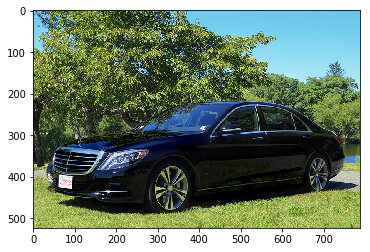

In [0]:
#load the image we want to test on
image_path = '/gdrive/My Drive/Examples/15.jpg'
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
output = image
plt.imshow(image)

In [0]:
#preprocessing on the testing image
image = cv2.resize(image, (96, 96))
image = image.astype('float') / 255.0
image = np.expand_dims(image, axis=0) #to get 4 dimentions as the input of the model should be in 4 dims

In [0]:
(categoryProba, colorProba) = model.predict(image)

categoryIdx = categoryProba[0].argmax()
colorIdx = colorProba[0].argmax()
categoryLabel = labeledCat.classes_[categoryIdx]
colorLabel = labeledColor.classes_[colorIdx]

category: sedan (73.39%)
color: Black (99.84%)


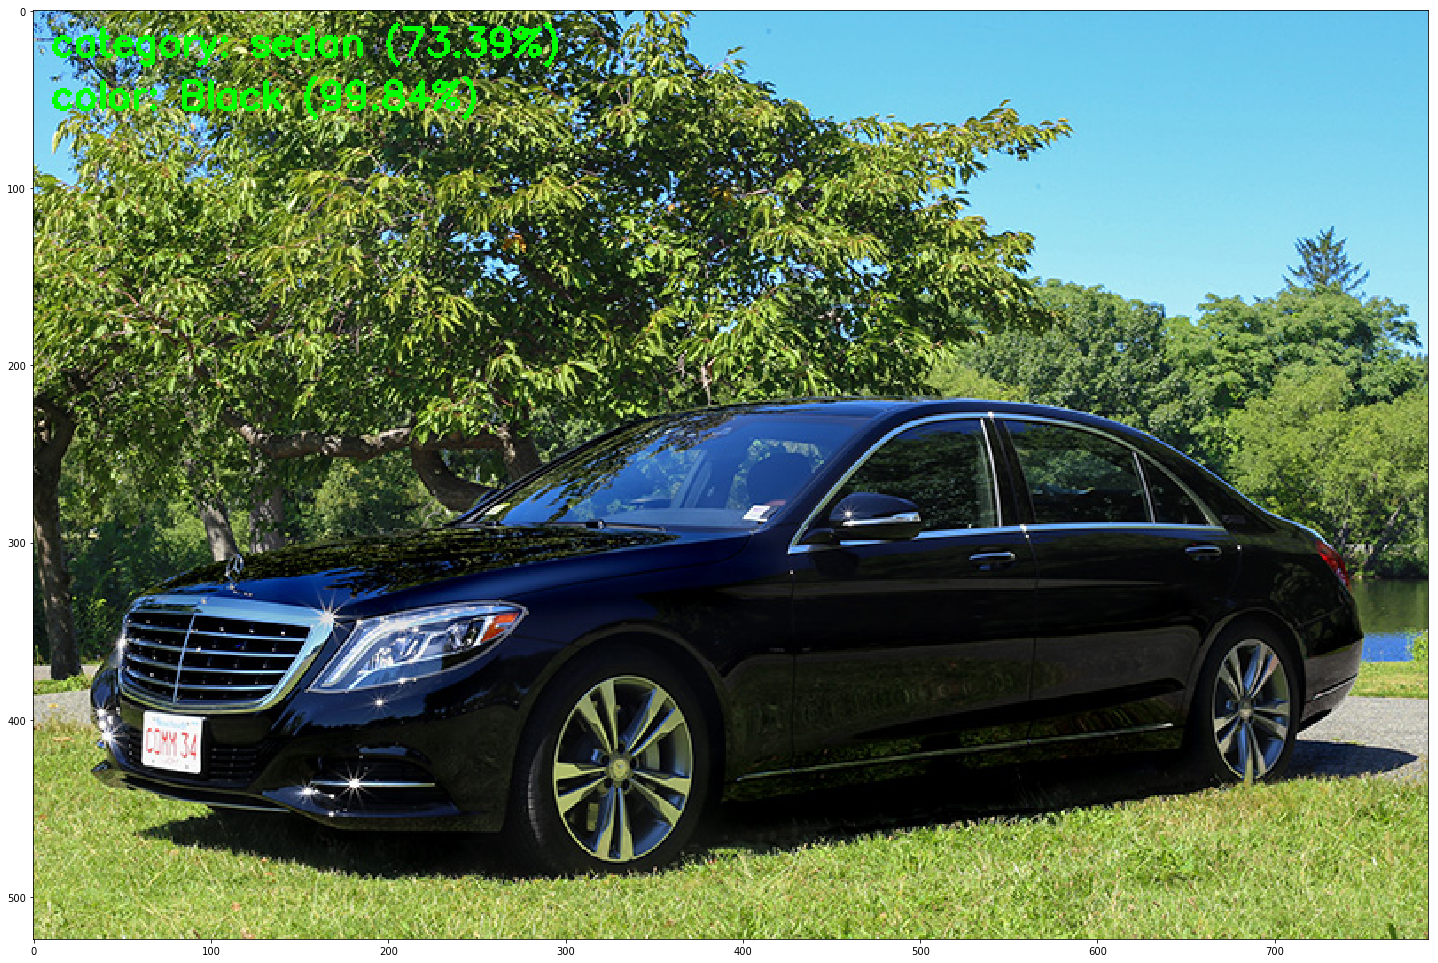

In [0]:
categoryText = f'category: {categoryLabel} ({(categoryProba[0][categoryIdx] * 100):.2f}%)'
colorText = f'color: {colorLabel} ({(colorProba[0][colorIdx] * 100):.2f}%)'

cv2.putText(output, categoryText, (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
cv2.putText(output, colorText, (10, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
 
# display the predictions to the terminal as well
print(categoryText)
print(colorText)
plt.figure(figsize=(25, 22))
plt.imshow(output)